## Capstone Project: Toxic Comment Classification

---

In this notebook, 

---
### Dataset

The Movie Review Dataset is a collection of movie reviews retrieved from the imdb.com website in the early 2000s by Bo Pang and Lillian Lee. The reviews were collected and made available as part of their research on natural language processing. The dataset can be downloaded from here:

* Movie Review Polarity Dataset (review polarity.tar.gz, 3MB).
  https://goo.gl/L6ZsLv

The dataset is comprised of 1,000 positive and 1,000 negative movie reviews drawn from an archive of the rec.arts.movies.reviews newsgroup hosted at IMDB. The authors refer to this dataset as the “polarity dataset“. The data has been cleaned up somewhat, for example:

* The dataset is comprised of only English reviews.
* All text has been converted to lowercase.
* There is white space around punctuation like periods, commas, and brackets.
* Text has been split into one sentence per line.


From this dataset, I will develop a sentiment analysis deep learning model to predict whether a given movie review is positive or negative.

### Outline

The notebook is divided into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Data
* [Step 1](#step1): Data Exploration and Exploratory Visualization
* [Step 2](#step2): Logistic Regression Classifier (Benchmark)
* [Step 3](#step3): Prepare the Data
* [Step 4](#step4): Convolutional Neural Network(CNN) model
* [Step 5](#step5): Recurrent Neural Network(RNN) model
* [Step 6](#step6): Pre-trained (Glove)
* [Step 7](#step7): Pre_trained (FastText)

---
<a id='step0'></a>
## Step 0: Import Data

### Import Movie Review Dataset

In the code cell below, I import a dataset of IMDB movie reviews. I will look at loading individual text files, then processing the directories of files. A few variables has been populated through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import string
from wordcloud import WordCloud
from PIL import Image
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping 
from sklearn.metrics import roc_auc_score
from keras.layers.convolutional import Conv1D, MaxPooling1D

#settings
color = sns.color_palette()
sns.set_style("whitegrid")
stopwords_eng = set(stopwords.words("english"))

Using TensorFlow backend.


In [2]:
# load text data
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')
submission = pd.read_csv('sample_submission.csv')
print('Trainning set contains {} records and testing set contains {} records.'.format(len(train),len(test)))

Trainning set contains 159571 records and testing set contains 153164 records.


---
<a id='step1'></a>
## Step 1: Data Exploration and Exploratory Visualization

### Inspect Dataset

In [ ]:
train.head()

In [ ]:
# class imbalance
labels = train.iloc[:,2:8]
row_sum = labels.sum(axis = 1)
# mark comments without any labels as "clean"
train['clean'] = (row_sum == 0)
print('Total comments is {}.'.format(len(train)))
print('The clean comments is {}, which is {} of total comments.'.format(train['clean'].sum(),train['clean'].sum()/len(train)))

### Missing Values

In [ ]:
# check for missing values in the trainning set
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()
missing_train, missing_test

### Example Comments

In [ ]:
all_types = ['clean', 'toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for t in all_types:
    record_number = random.randint(1, train[t].sum())
    print('The {}th record of "{}" comments is:'.format(record_number,t))
    print(train[train[t] == 1].iloc[record_number,1])
    print('')
    

### Distribution of Subtypes

In [ ]:
# plot different types of labels
column_sum = pd.Series(labels.sum(axis = 0))
clean = pd.Series(train['clean'].sum(), index = ['clean'])
# add clean document amount as a new type
column_sum = pd.concat([clean, column_sum])

# barplot for different labels
plt.figure(figsize=(8,4.5))
ax = sns.barplot(column_sum.index, column_sum.values, palette = "Paired")
plt.xlabel('Subtype', fontsize = 12)
plt.ylabel('number of records', fontsize = 12)

# add the text labels
for rect, label in zip(ax.patches, column_sum.values):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label,ha = 'center', va='bottom')

# save the figure as .eps file
fig_subtype = ax.get_figure()
fig_subtype.savefig('figure/subtype.eps')
plt.show()

### Multi-tagging

In [ ]:
multi_tags = [ sum(row_sum == i) for i in range(7)]
multi_tags = pd.Series(multi_tags, index = [0,1,2,3,4,5,6])
plt.figure()
color_reds = sns.color_palette("Reds", n_colors=7, desat=1)

# barplot for different labels
plt.figure(figsize=(8,4.5))
ax_1 = sns.barplot(multi_tags.index, multi_tags.values, palette = color_reds)
plt.xlabel('number of tags', fontsize = 12)
plt.ylabel('number of records', fontsize = 12)

# add the text labels
for rect, label in zip(ax_1.patches, multi_tags.values):
        ax_1.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label,ha = 'center', va='bottom')
        
# save the figure as .eps file
fig_multi_tags = ax_1.get_figure()
fig_multi_tags.savefig('figure/multi_tags.eps')
plt.show()

### Crosstab

In [ ]:
# crosstab
subtypes = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
i = 1
plt.figure(figsize = (15,3.5))
for subtype in subtypes:
    plt.subplot(1,5,i)
    cross = sns.heatmap(pd.crosstab(train['toxic'],train[subtype]),annot = True,
                        fmt = '', cbar = False, cmap = "Blues")
    i += 1
plt.show()  

# save the figure
fig_cross = cross.get_figure()
fig_cross.savefig('figure/crosstab.eps')

### Comments Length Distribution

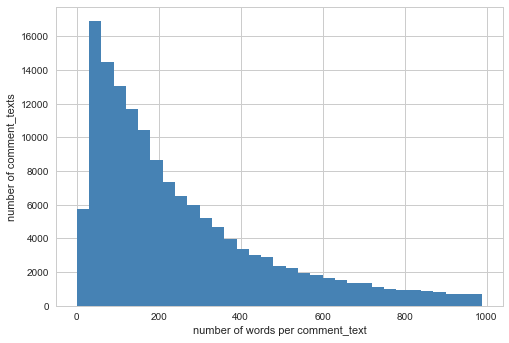

In [63]:
# calculate the number of words per comment
n_words = [len(comment) for comment in train.comment_text]

# histogram plot of the number of words each comment contains
fig_n_words = plt.figure()
plt.hist(n_words,bins = np.arange(0,1000,30), color='steelblue')
plt.xlabel('number of words per comment_text')
plt.ylabel('number of comment_texts')
plt.show()

# save the figure
fig_n_words.savefig('figure/n_words.eps')

### Wordclouds Plot

In [ ]:
# frequent words 
def wordcloud_generator(subtype, background, mask_file):
    subset = train[train[subtype] == True]
    subset_text = subset.comment_text.values
    # import mask file
    mask = np.array(Image.open(mask_file))
    mask = mask[:, :, 1]
    # create a wordcloud for the text 
    wordcloud = WordCloud(background_color = background, mask = mask, stopwords = stopwords_eng)
    wordcloud.generate(" ".join(subset_text))    
    return wordcloud

In [ ]:
# wordcloud plot for clean comments
wordcloud_clean = wordcloud_generator('clean','white','image/mask_clean.jpg')
wordcloud_clean_plot = plt.imshow(wordcloud_clean.recolor(colormap = 'viridis', random_state = 29), interpolation = 'bilinear')
plt.axis("off")
plt.show()

#save the figure
fig_wordcloud_clean = wordcloud_clean_plot.get_figure()
fig_wordcloud_clean.savefig('figure/wordcloud_clean.eps')

In [ ]:
# wordcloud plot for subtypes of toxic comments
toxic_types = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
colormaps = ['magma', 'Reds', 'inferno', 'Paired_r', 'Paired_r', 'plasma']

plt.subplots(3,2, figsize=(10,15))
i = 1
for toxic_type, colormap in zip(toxic_types, colormaps):
    plt.subplot(3,2,i)
    wordcloud_toxic = wordcloud_generator(toxic_type,'black','image/mask_toxic.jpg')
    wordcloud_toxic_plot = plt.imshow(wordcloud_toxic.recolor(colormap = colormap, random_state = 29), interpolation = 'bilinear')
    plt.axis("off")
    plt.gca().set_title(toxic_type)
    i += 1
plt.show()

# save the figure
fig_wordcloud_toxic = wordcloud_toxic_plot.get_figure()
fig_wordcloud_toxic.savefig('figure/wordcloud_toxic.eps')

---
<a id='step2'></a>
## Step 2: Logistic Regression Classifier (Benchmark)


In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf = True,
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    stop_words = 'english',
    ngram_range = (1, 1),
    max_features = 10000)
    
word_vectorizer.fit(train_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf = True,
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    stop_words = 'english',
    ngram_range = (2, 6),
    max_features = 50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

In [ ]:
train_features = hstack([train_word_features, train_char_features])
test_features = hstack([test_word_features, test_char_features])

In [ ]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C = 0.2, solver = 'sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv = 3, scoring = 'roc_auc'))
    scores.append(cv_score)

    print('CV score for class "{}"" is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    # [:,1] for those = 1, which is toxic
    submission[class_name] = classifier.predict_proba(test_features)[:,1]
print('Total CV score is {}'.format(np.mean(scores)))
submission.to_csv('submission.csv', index = False)

---
<a id='step3'></a>
## Step 3: Prepare the Data


In [3]:
# funtion to preprocess text data
def clean_doc(text_record):
    # split tokens by white space
    tokens = text_record.split()
    # remove punctuation from each string
    table = str.maketrans({key: None for key in string.punctuation})
    tokens = [token.translate(table) for token in tokens]
    # remove tokens that are not alphabetic
    tokens = [token for token in tokens if token.isalpha()]
    # convert letters to lower case
    tokens = [token.lower() for token in tokens]
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # remove short words (one letter)
    tokens = [token for token in tokens if len(token) > 1]
    sentence = ' '.join(tokens)
    return sentence

In [4]:
# preprocess all comment texts in the trainning set and testing set
# take first 20000 records to test
train_text = train.comment_text[:8000].copy()
val_text = train.comment_text[8000:9000].copy()
test_text = train.comment_text[9000:10000].copy()

for i in range(8000):
    train_text[i] = clean_doc(train_text[i])
for j in range(8000,9000):
    val_text[j] = clean_doc(val_text[j])
for k in range(9000,10000):
    test_text[k] = clean_doc(test_text[k])    

#train_text = [clean_doc(comment) for comment in train_text]
#test_text = [clean_doc(comment) for comment in test_text]
    
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train[class_names].values[:8000]
y_val = train[class_names].values[8000:9000]
y_test = train[class_names].values[9000:10000]

In [ ]:
# Compare the comment text after preprocessed
print('The 0th comment text in trainning set is:')
print(train.comment_text[0])
print('The 0th comment text in trainning set after preprocessing is:')
print(train_text[0])

### Word Tokenization

In [5]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(train_text)
train_encoded = tokenizer.texts_to_sequences(train_text)
val_encoded = tokenizer.texts_to_sequences(val_text)
test_encoded = tokenizer.texts_to_sequences(test_text)
# vocabulary size
print('The vocabulary size is {}.'.format(len(tokenizer.word_index)))
# examples
print(train_encoded[0])

The vocabulary size is 32994.
[527, 53, 41, 422, 3851, 14047, 964, 224, 2124, 6593, 4179, 3596, 42, 1040, 9502, 2690, 8, 9, 156, 342, 6, 2, 52, 12, 3587]


In [ ]:
tokenizer.word_index

### Word Padding

In [6]:
maxlen = 200
X_train = pad_sequences(train_encoded, maxlen = maxlen, padding = 'post')
X_val = pad_sequences(val_encoded, maxlen = maxlen, padding = 'post')
X_test = pad_sequences(test_encoded, maxlen = maxlen, padding = 'post')

### Shuffle and Split Data

Now all text data have been converted into numerical features. Next is to split the data (both features and their labels) into training and validation sets. 80% of the data will be used for training and 20% for validation.

In [43]:
#X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=30)

---
<a id='step4'></a>
## Step 4: 


In [10]:
# define new callback for ROC AUC score
class roc_callback(Callback):   
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

In [29]:
# function that compile, train and evaluate model
def train_evaluate(model,X_train, y_train, X_val, y_val, X_test, y_test, batch_size, epochs, filepath):
    # compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # train the model 
    batch_size = batch_size
    epochs = epochs
    checkpointer =  ModelCheckpoint(filepath=filepath, 
                                    verbose=1, 
                                    save_best_only=True)
    roc = roc_callback(training_data=(X_train,y_train),
                       validation_data=(X_val, y_val)) 
    model.fit(X_train,y_train,
              validation_data=(X_val, y_val),
              batch_size=batch_size,
              epochs=epochs,
              callbacks=[roc,checkpointer])
    # load the model with the best validation loss
    model.load_weights(filepath)
    y_pred = model.predict(X_test)
    # evaluate the model on test set and report ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC score: {}'.format(roc_auc))
    return

### Model Architecture :CNN

In [16]:
# build CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(max_features, 100, input_length=maxlen))
model_cnn.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.25))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(6, activation="sigmoid"))

#summary
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 193, 32)           25632     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 96, 32)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 96, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 89, 64)            16448     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 44, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 44, 64)            0         
__________

In [32]:
train_evaluate(model_cnn,
               X_train,y_train,
               X_val,y_val,
               X_test,y_test,
               batch_size=50, 
               epochs=5,
               filepath='saved_models/weights.best.from_scratch_cnn.hdf5')

Train on 8000 samples, validate on 1000 samples
Epoch 1/5
roc-auc: 0.998 - roc-auc_val: 0.8864                                                                                                    

### Model Architecture :RNN

In [30]:
# build model
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, 100, input_length=maxlen))
model_rnn.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model_rnn.add(GlobalMaxPool1D())
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(50, activation="relu"))
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(6, activation="sigmoid"))

# summary
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total para

In [31]:
train_evaluate(model_rnn,
               X_train,y_train,
               X_val,y_val,
               X_test,y_test,
               batch_size=50, 
               epochs=5,
               filepath='saved_models/weights.best.from_scratch_rnn.hdf5')

Train on 8000 samples, validate on 1000 samples
Epoch 1/5
roc-auc: 0.9176 - roc-auc_val: 0.89                                                                                                    

---
<a id='step5'></a>
## Step 5: Models with Transfer Learning

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

In [35]:
# load the whole embedding into memory
def create_embeddings_index(filename):
    embeddings_index = dict()
    f = open(filename, encoding = 'utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index.keys()))
    return embeddings_index

In [36]:
# create a weight matrix for words in training docs (look up word vectors in embeddings_index)
def create_embeddings_matrix(tokenizer, embeddings_index):
    vocab_size = len(tokenizer.word_index) + 1
    embeddings_matrix = np.zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embeddings_vector = embeddings_index.get(word)
        if embeddings_vector is not None:
            embeddings_matrix[i] = embeddings_vector
    return embeddings_matrix

### Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

|bottleneck features|following layers|total parameters|accuracy|
|:----------:|:-------:|:----:|:----:|
|VGG-19|Dense(512), Dense(133)|330,885|73.3254%|
|ResNet50|Dense(512), Dense(133)|1,117,317|76.6746%|
|Inception|Dense(512), Dense(133)|1,117,317|78.3493%|
|Xception|Dense(512), Dense(133)|1,117,317|81.8182%|

As shown in the above table, I have tested four pre-trained models with similar architectures and Xception shows the best accuracy of 81%. 

As for the architecture, I added a GlobalAveragePooling layer first to minimize overfitting and to detect if a single feature exists. The output is 2048 then, if add a output layer directly, it reduces the nodes drastically and may lose some important information. So I add a Dense layer of 512 nodes with RELU activation, and then the output layer with 133 nodes correspoding to the total kinds of dogs. 

In [38]:
# GloVe model
# load the whole embedding into memory
embeddings_index_glove = create_embeddings_index('pre_trained/glove.6B.100d.txt')
# create a weight matrix for the embedding layer from a loaded embedding
embeddings_matrix_glove = create_embeddings_matrix(tokenizer, embeddings_index_glove)

Loaded 400000 word vectors.


In [48]:
# define the model
vocab_size = len(tokenizer.word_index) + 1

model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 100, weights = [embeddings_matrix_glove], input_length = maxlen, trainable = True))
model_glove.add(LSTM(60, return_sequences=True,name='lstm_layer'))
model_glove.add(GlobalMaxPool1D())
model_glove.add(Dropout(0.1))
model_glove.add(Dense(50, activation="relu"))
model_glove.add(Dropout(0.1))
model_glove.add(Dense(6, activation="sigmoid"))

# summary
model_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 100)          3299500   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 306       
Total para

In [43]:
#model_glove.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [49]:
train_evaluate(model_glove,
               X_train,y_train,
               X_val,y_val,
               X_test,y_test,
               batch_size=50, 
               epochs=5,
               filepath='saved_models/weights.best.glove.hdf5')

Train on 8000 samples, validate on 1000 samples
Epoch 1/5
roc-auc: 0.9065 - roc-auc_val: 0.9036                                                                                                    

### (IMPLEMENTATION) Compile the Model

In [ ]:
### Compile the model.
def compile_model(model):
    model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
    return

#compile_model(VGG19_model)
#compile_model(ResNet50_model)
#compile_model(Inception_model)
compile_model(Xception_model)

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
from keras.callbacks import ModelCheckpoint  
### Train the model.
def train_model(model, bottleneck_features, model_checkpoint_path, epochs = 20, batch_size = 20):
    checkpointer = ModelCheckpoint(filepath = model_checkpoint_path, 
                                   verbose = 1, save_best_only = True)
    
    model.fit(bottleneck_features['train'], train_targets,
              validation_data = (bottleneck_features['valid'], valid_targets),
              epochs = epochs, batch_size = batch_size, callbacks = [checkpointer], verbose = 1) 

#train_model(VGG19_model, VGG19_bnf, 'saved_models/weights.best.VGG19.hdf5')
#train_model(ResNet50_model, ResNet50_bnf, 'saved_models/weights.best.ResNet50.hdf5')
#train_model(Inception_model, Inception_bnf, 'saved_models/weights.best.Inception.hdf5')
train_model(Xception_model, Xception_bnf, 'saved_models/weights.best.Xception.hdf5')

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### Load the model weights with the best validation loss.
def load_weights(model, model_checkpoint_path):
    model.load_weights(model_checkpoint_path)
    return

#load_weights(VGG19_model, 'saved_models/weights.best.VGG19.hdf5')
#load_weights(ResNet50_model, 'saved_models/weights.best.ResNet50.hdf5')
#load_weights(Inception_model, 'saved_models/weights.best.Inception.hdf5')
load_weights(Xception_model, 'saved_models/weights.best.Xception.hdf5')


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### Calculate classification accuracy on the test dataset.
def model_accuracy(model, bottleneck_features):
    #get index of predicted dog breed for each image in test set
    model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in bottleneck_features['test']]
    # report test accuracy
    test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)
    
#model_accuracy(VGG19_model, VGG19_bnf)
#model_accuracy(ResNet50_model, ResNet50_bnf)
#model_accuracy(Inception_model, Inception_bnf)
model_accuracy(Xception_model, Xception_bnf)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

---
<a id='step6'></a>
## Step 6: Write your Algorithm

